In [42]:
import torch
import torchvision
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.datasets.folder import default_loader
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader
from torch import Tensor
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

from pathlib import Path
import re
import time
from typing import Tuple, List, Dict, Optional, Callable, Any, Union
import os
import copy

%matplotlib inline
plt.ion()   # Use interactive mode for plotting, makes plots show updates automatically

YOLO_TRAIN_DIR = Path("/home/lex/data/Spatial_Monitoring_and_Insect_Behavioural_Analysis_Dataset/YOLOv4_Training_and_Test_Dataset/training")
YOLO_TEST_DIR = Path("/home/lex/data/Spatial_Monitoring_and_Insect_Behavioural_Analysis_Dataset/YOLOv4_Training_and_Test_Dataset/testing")
CLASSIFIER_TRAIN_DIR = Path("out/classification/training")
CLASSIFIER_TEST_DIR = Path("out/classification/testing")

CLASSIFIER_TRAIN_DIR.mkdir(parents=True, exist_ok=True)
CLASSIFIER_TEST_DIR.mkdir(parents=True, exist_ok=True)

INSECT_TXT_REGEX = re.compile(r"insect_(\d+).txt")

TRAIN = "train"
VALIDATION = "val"

# Use this flag if you want the cell that crops the images to run. If you 
# already have the cropped images, you should set this to False to save time 
# (~15 mins on my laptop)
DO_CROP_IMAGES = False #

In [38]:
# Get list of target classes (e.g. bee/wasp, flower, etc.) and corresponding zero-based index for that class
TARGET_TO_NAME = pd.Series(
    {
        0: "honeybee_vespidae", 
        1: "flower", 
        2: "syrphidae", 
        3: "lepidoptera"
    }, 
    name="target_name"
)
NAME_TO_TARGET = {v: k for k, v in TARGET_TO_NAME.items()}
TARGET_TO_NAME

0    honeybee_vespidae
1               flower
2            syrphidae
3          lepidoptera
Name: target_name, dtype: object

In [39]:
# Get DataFrame where each row corresponds to a unique image+bounding box for every
# instance of an insect that occurs in the (full-resolution) training images
csv_columns = ["target", "centre_x", "centre_y", "box_width", "box_height"]
extra_columns = ["image"]

dataframes = {
    "train": pd.DataFrame(columns=[*extra_columns, *csv_columns]),
    "test": pd.DataFrame(columns=[*extra_columns, *csv_columns])
}

for directory, phase in zip([YOLO_TRAIN_DIR, YOLO_TEST_DIR], [TRAIN, VALIDATION]):
    for file in directory.iterdir():
        match = INSECT_TXT_REGEX.match(file.name)
        if match:
            row = pd.read_csv(file, sep=" ", names=csv_columns)
            
            # Get corresponding image for this insect 
            image_fp = file.with_suffix(".png")
            row["image"] = str(image_fp)

            dataframes[phase] = pd.concat([dataframes[phase], row], ignore_index=True)

dataframes["train"].head()

KeyError: 'val'

In [ ]:
# Add insect type as human-friendly string to dataframe just because
for phase in [TRAIN, VALIDATION]:
    dataframes[phase] = dataframes[phase].join(TARGET_TO_NAME, on="target")

dataframes[TRAIN].head()

,image,target,centre_x,centre_y,box_width,box_height,target_name
0,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,0.438305,0.512250,0.016172,0.033593,honeybee_vespidae
1,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,0.131612,0.412750,0.011568,0.035130,honeybee_vespidae
2,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,0.394792,0.306481,0.017708,0.025926,honeybee_vespidae
3,/home/lex/data/Spatial_Monitoring_and_Insect_B...,1,0.294792,0.488889,0.030208,0.055556,flower
4,/home/lex/data/Spatial_Monitoring_and_Insect_B...,1,0.514062,0.241204,0.038542,0.065741,flower


In [ ]:
def crop_to_insect(image: np.ndarray, centre_x: int, centre_y: int, height_width:int=128):
    """Convert a row from our insect bounding boxes DataFrame into a cropped image."""
    # Note we're not actually using the original height/width of bounding boxes, 
    # we want something a little less precise and more consistent
    top_y = int(centre_y - 0.5 * height_width)
    bottom_y = int(centre_y + 0.5 * height_width)
    left_x = int(centre_x - 0.5 * height_width)
    right_x = int(centre_x + 0.5 * height_width)

    height, width, channels = image.shape

    # print(f"Before, top_y={top_y}, bottom_y={bottom_y}, left_x={left_x}, right_x={right_x}")
    # Check if our crop goes out of bounds
    pad_width = [[0, 0], [0, 0], [0, 0]] # padding width for (before, after) for each axis of image arrays
    if top_y < 0:
        pad_width[0][0] = abs(top_y)
        bottom_y += abs(top_y)
        top_y = 0
    if bottom_y > height:
# train_dataset = InsectDataset(CLASSIFIER_TRAIN_DIR)
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataset = InsectDataset(CLASSIFIER_TEST_DIR)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        pad_width[0][1] = abs(bottom_y - height) + 1
    if left_x < 0:
        pad_width[1][0] = abs(left_x)
        right_x += abs(left_x)
        left_x = 0
    if right_x > width:
        pad_width[1][1] = abs(right_x - width) + 1
    # print(f"After, top_y={top_y}, bottom_y={bottom_y}, left_x={left_x}, right_x={right_x}")

    image_padded = np.pad(image, pad_width=pad_width, mode="symmetric")
    image_cropped = image_padded[top_y:bottom_y, left_x:right_x]

    return image_cropped

In [ ]:
# Make sure our output directories exist before we put files into them
for target in TARGET_TO_NAME:
    print(f"Creating training/ and testing/ directories for '{target}' in '{CLASSIFIER_TRAIN_DIR}' and '{CLASSIFIER_TEST_DIR}', respectively")
    (CLASSIFIER_TRAIN_DIR / target).mkdir(parents=True, exist_ok=True)
    (CLASSIFIER_TEST_DIR / target).mkdir(parents=True, exist_ok=True)

Creating training/ and testing/ directories for 'honeybee_vespidae' in 'out/classification/training' and 'out/classification/testing', respectively
Creating training/ and testing/ directories for 'flower' in 'out/classification/training' and 'out/classification/testing', respectively
Creating training/ and testing/ directories for 'syrphidae' in 'out/classification/training' and 'out/classification/testing', respectively
Creating training/ and testing/ directories for 'lepidoptera' in 'out/classification/training' and 'out/classification/testing', respectively


In [74]:
if DO_CROP_IMAGES:
    # Now convert those fractional positions above to absolute pixel values (e.g. 
    # centre_x=0.44 --> 0.44*1920~=845)
    for phase, input_dir, output_dir in zip([TRAIN, VALIDATION], [YOLO_TRAIN_DIR, YOLO_TEST_DIR], [CLASSIFIER_TRAIN_DIR, CLASSIFIER_TEST_DIR]):
        df = dataframes[phase]

        # We'll store these back into the dataframe to store the integer, not fractional,
        # measurements. All images are probably the same resolution, but do it this
        # way just in case there are differing resolutions
        centre_ys = pd.Series(index=df.index, name="centre_y", dtype=int)
        centre_xs = pd.Series(index=df.index, name="centre_x", dtype=int)
        box_heights = pd.Series(index=df.index, name="box_height", dtype=int)
        box_widths = pd.Series(index=df.index, name="box_width", dtype=int)
        image_heights = pd.Series(index=df.index, name="image_height", dtype=int)
        image_widths = pd.Series(index=df.index, name="image_width", dtype=int)
        
        for index, row in tqdm(df.iterrows(), total=len(df), desc=phase):
            row = row.squeeze()

            input_fp = input_dir / row["image"]
            image = cv2.imread(str(input_fp))
            image_height, image_width, num_channels = image.shape

            # Store conversions from fractional to absolute values for later reuse
            centre_y = int(row["centre_y"] * image_height)
            centre_x = int(row["centre_x"] * image_width)
            box_height = int(row["box_height"] * image_height)
            box_width = int(row["box_width"] * image_width)

            # Crop image and save to output directory
            image_cropped = crop_to_insect(image=image, centre_x=centre_x, centre_y=centre_y)

            input_stem = input_fp.stem
            input_suffix = input_fp.suffix
            target_name = row["target_name"]
            
            output_name = f"{input_stem}_{row['target']}_{centre_x}_{centre_y}{input_suffix}"
            output_fp = output_dir / target_name / output_name
            # print(output_fp)
            
            cv2.imwrite(str(output_fp), image_cropped)

            # Save these as integers, maybe for later
            centre_ys[index] = centre_y
            centre_xs[index] = centre_x
            box_heights[index] = box_height
            box_widths[index] = box_width
            image_heights[index] = image_height
            image_widths[index] = image_width
        
        dataframes[phase] = df.assign(
            centre_y=centre_ys,
            centre_x=centre_xs,
            box_height=box_heights,
            box_width=box_widths,
            image_height=image_heights,
            image_width=image_widths
        )
        dataframes[phase] = dataframes[phase].astype({
            "centre_y": int,
            "centre_x": int,
            "box_height": int,
            "box_width": int,
            "image_height": int,
            "image_width": int
        })
        
        
    dataframes[TRAIN].head()

test: 100%|██████████| 3246/3246 [02:32<00:00, 21.28it/s]


,image,target,centre_x,centre_y,box_width,box_height,target_name,image_height,image_width
0,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,841,553,31,36,honeybee_vespidae,1080,1920
1,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,252,445,22,37,honeybee_vespidae,1080,1920
2,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,758,330,33,28,honeybee_vespidae,1080,1920
3,/home/lex/data/Spatial_Monitoring_and_Insect_B...,1,566,528,57,60,flower,1080,1920
4,/home/lex/data/Spatial_Monitoring_and_Insect_B...,1,986,260,74,71,flower,1080,1920


In [44]:
class InsectDataset(Dataset):
    def __init__(self, directory: Union[Path, str], transforms, exclude_classes: List[str]) -> None:
        super().__init__()

        if not isinstance(directory, Path):
            directory = Path(directory)
        self.directory = directory
        self.transforms = transforms
        self.exclude_classes = exclude_classes

        self.class_names = self.find_class_names()
        self.images = self.find_images()

        # self.transforms = transforms.Compose(
        #     [
        #         transforms.CenterCrop(32),
        #         transforms.ToTensor(),
        #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #     ]
        # )

    def find_class_names(self):
        class_names = [fp.name for fp in self.directory.iterdir() if fp.is_dir() and fp.name not in self.exclude_classes]
        return class_names

    def find_images(self) -> List[str]:
        images = []
        for class_name in self.class_names:
            class_index = NAME_TO_TARGET[class_name]
            class_dir = self.directory / class_name
            images.extend([(video_file, class_index) for video_file in class_dir.iterdir()])
        
        return images

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index):
        image_fp, target = self.images[index]
        image = default_loader(image_fp)
        image = self.transforms(image)

        return image, target

    def __str__(self) -> str:
        return f"InsectDataset (directory={self.directory}, {len(self)} images)"

    def __repr__(self) -> str:
        return str(self)

In [57]:
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(100),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    VALIDATION: transforms.Compose([
        # transforms.Resize(256),
        transforms.CenterCrop(100),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_directories = {
    TRAIN: CLASSIFIER_TRAIN_DIR,
    VALIDATION: CLASSIFIER_TEST_DIR
}

exclude_classes = ["flower"]

datasets = {
    phase: InsectDataset(data_directories[phase], transforms=data_transforms[phase], exclude_classes=exclude_classes) for phase in [TRAIN, VALIDATION]
}
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=4, shuffle=True, drop_last=True) for phase in [TRAIN, VALIDATION]
}
dataset_sizes = {phase: len(datasets[phase]) for phase in [TRAIN, VALIDATION]}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


In [58]:

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    """Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html"""
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [TRAIN, VALIDATION]:
            if phase == TRAIN:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == TRAIN:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == VALIDATION and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

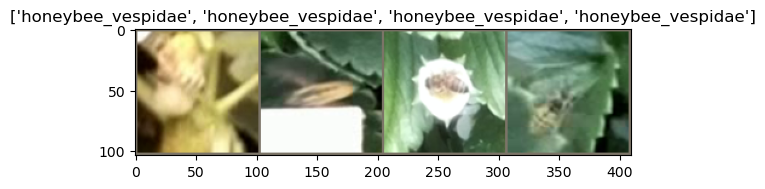

In [60]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[TARGET_TO_NAME[int(x)] for x in classes])

In [61]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[VALIDATION]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {TARGET_TO_NAME[int(preds[j])]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [62]:
# import torch.backends.cudnn as cudnn
# cudnn.benchmark = True

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(TARGET_TO_NAME))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [63]:
model_ft = train_model(
    model=model_ft, 
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    criterion=criterion, 
    optimizer=optimizer_ft, 
    scheduler=exp_lr_scheduler,
    num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.3284 Acc: 0.9002
val Loss: 0.2131 Acc: 0.9258

Epoch 1/24
----------
train Loss: 0.2069 Acc: 0.9329
val Loss: 0.7929 Acc: 0.6261

Epoch 2/24
----------
train Loss: 0.1888 Acc: 0.9269
val Loss: 0.1988 Acc: 0.9288

Epoch 3/24
----------
train Loss: 0.1687 Acc: 0.9453
val Loss: 0.2547 Acc: 0.9139

Epoch 4/24
----------
train Loss: 0.1535 Acc: 0.9426
val Loss: 0.1811 Acc: 0.9258

Epoch 5/24
----------
train Loss: 0.1505 Acc: 0.9543
val Loss: 0.1629 Acc: 0.9347

Epoch 6/24
----------
train Loss: 0.1272 Acc: 0.9556
val Loss: 0.1790 Acc: 0.9347

Epoch 7/24
----------
train Loss: 0.1095 Acc: 0.9600
val Loss: 0.1472 Acc: 0.9407

Epoch 8/24
----------
train Loss: 0.1061 Acc: 0.9600
val Loss: 0.1538 Acc: 0.9377

Epoch 9/24
----------
train Loss: 0.0923 Acc: 0.9680
val Loss: 0.1450 Acc: 0.9466

Epoch 10/24
----------
train Loss: 0.0811 Acc: 0.9696
val Loss: 0.1323 Acc: 0.9436

Epoch 11/24
----------
train Loss: 0.0820 Acc: 0.9686
val Loss: 0.1399 Acc: 0.9436

Ep

In [35]:
test_targets = [d[1] for d in datasets[VALIDATION]]
test_targets

from collections import Counter
Counter(test_targets)

Counter({3: 15, 0: 302, 2: 20})